# Chapter 4 - Degree Correlations

In this notebook, we explore various notions of degree correlation (assortativity, disassortativity) and related measures.

As with the previous notebooks, make sure to set the data directory properly in the next cell

In [1]:
datadir = '../Datasets/'

In [2]:
import igraph as ig
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from collections import Counter


In [3]:
## define the colors and node sizes here
cls_edges = 'gainsboro'
cls = ['silver','dimgray','black']
sz = [6,9,12]

## Some useful functions

* deg_corr: compute $k_{nn}(l)$ for all degrees $l$, as defined in section 4.3 (undirected)
* deg_corr_directed: compute $k_{nn}^{mode1,mode2}(l)$ for all degrees $l$, as defined in section 4.5; mode1 and mode2 can be 'in', 'out' or 'all'
* deg_corr_neutral: for neutral graph with same degree distribution as in G
* corr_exp: correlation exponent via linear regression (taking logs) as in section 4.3
* rich_club: rich club coefficient (section 4.3) for a given degree $l$

In [41]:
2*2/5+3*1/5+4*2/5

3.0

In [42]:
np.mean([2,2,3,4,4])

3.0

In [ ]:
[2,2,3,4,4] = 2*2/5+3*1/5+4*2/5

In [4]:
## Degree correlation functions
# undirected
def deg_corr(G):
    idx = {v:k for k,v in enumerate([i for i in set(G.degree())])}
    idx_inv = {k:v for k,v in enumerate(idx)}
    deg = G.degree()
    L = [[] for i in range(len(idx))]
    for v in G.vs():
        w = [deg[i] for i in G.neighbors(v)] 
        L[idx[v.degree()]].extend(w)
    return {idx_inv[i]:np.mean(L[i]) for i in range(len(L))}

## degree correlation for neutral graph with degree distribution in G
def deg_corr_neutral(G, mode='all'):
    x = G.degree(mode=mode)
    return np.mean([i**2 for i in x])/np.mean(x)    

## k_nn^{mode1,mode2}(l) : average mode2-degree of mode1-neighbours of nodes with mode1-degree = l
def deg_corr_directed(G, mode1='all', mode2='all'):
    idx = {v:k for k,v in enumerate([i for i in set(G.degree(mode=mode1))])}
    idx_inv = {k:v for k,v in enumerate(idx)}
    deg = G.degree(mode=mode2)
    L = [[] for i in range(len(idx))]
    for v in G.vs():
        w = [deg[i] for i in G.neighbors(v, mode='out')] ## do each link only once
        L[idx[v.degree(mode=mode1)]].extend(w)
    return {idx_inv[i]:np.mean(L[i]) for i in range(len(L)) if len(L[i])>0}

## Correlation exponent via linear regression (taking logs)
def corr_exp(G):
    ## compute knn's
    knn = deg_corr(G)
    # Fit the regression
    regressor = LinearRegression()  
    x = [np.log(i) for i in knn.keys()]
    y = [np.log(i) for i in knn.values()]
    regressor.fit(np.array(x).reshape(-1,1), y)
    return regressor.coef_[0]

## for a fixed l -- can be slow for multiple l's
def rich_club(g, l=1):
    g.vs()['degree'] = g.degree()
    l_max = np.max(g.degree())
    c = Counter(g.degree())
    n = g.vcount()
    moment = np.sum([k*c[k]/n for k in c])**2
    S = [k*c[k]/n for k in c if k>=l]
    phi_hat = np.sum([x*y for x in S for y in S])*g.ecount()/moment
    G = g.subgraph([v for v in g.vs() if v['degree']>=l])
    phi = G.ecount()
    return phi/phi_hat     


## US Airports -  Volume of Passengers

We use the same dataset as in previous chapter: a directed, weighted graph where edge weights are passenger volumes between airports. The weights are not used in this notebook, as we only consider node degrees.


In [5]:
## read edges and build weighted directed graph
D = pd.read_csv(datadir+'Airports/connections.csv')
g = ig.Graph.TupleList([tuple(x) for x in D.values], directed=True, edge_attrs=['weight'])

## read vertex attributes and add to graph
A = pd.read_csv(datadir+'Airports/airports_loc.csv')
lookup = {k:v for v,k in enumerate(A['airport'])}
l = [lookup[x] for x in g.vs()['name']]
g.vs()['layout'] = [(A['lon'][i],A['lat'][i]) for i in l]
g.vs()['state'] = [A['state'][i] for i in l]
g.vs()['city'] = [A['city'][i] for i in l]

## drop loops; this will also remove edge weights, but we won't need those
g = g.simplify()

## add a few more attributes for visualization
g.vs()['size'] = sz[1]
g.vs['color'] = cls[1]
g.es()['color'] = cls_edges


## Directed Degree Correlation Functions (4 cases)

Plot $k_{nn}^{mode1,mode2}(l)$ for all degrees $l$, where mode1 and mode2 are either 'in' or 'out'.
As detailed in section 4.5, this is the average mode2-degree of mode1-neighbours of nodes with mode1-degree = $l$.
Dashed lines are for neutral graphs.

While not identical, we see that the four plots are very similar, showing a slightly negative correlation except for the nodes of small degree. This similarity is not surprising as in this directed graph the edges very often come in pairs: when there are flights from A to B, there are very often flights from B to A.


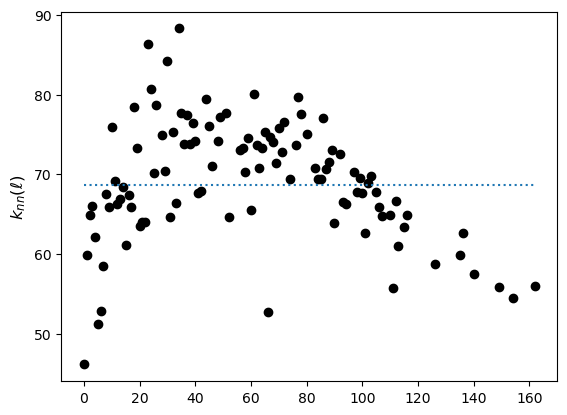

In [6]:
knn = deg_corr_directed(g,'in','in')
x = list(knn.keys())
y = list(knn.values())
r = deg_corr_neutral(g,'in')
plt.scatter(x,y,c='black')
plt.hlines(y=r,xmin=min(x),xmax=max(x),linestyles=':')
plt.ylabel(r'$k_{nn}(\ell)$',fontsize=12);
#plt.savefig('degree_corr_in_in.eps')

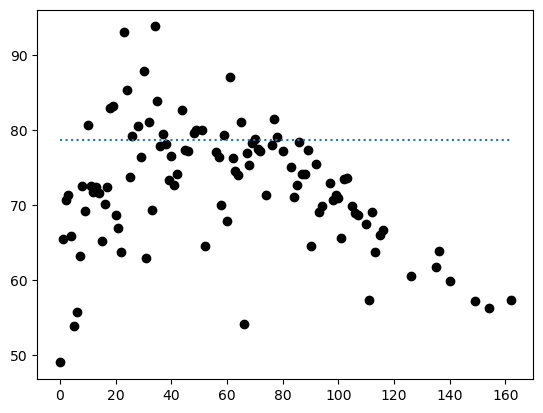

In [7]:
knn = deg_corr_directed(g,'in','out')
x = list(knn.keys())
y = list(knn.values())
r = deg_corr_neutral(g,'out')
plt.scatter(x,y,c='black')
plt.hlines(y=r,xmin=min(x),xmax=max(x),linestyles=':');
#plt.savefig('degree_corr_in_out.eps')

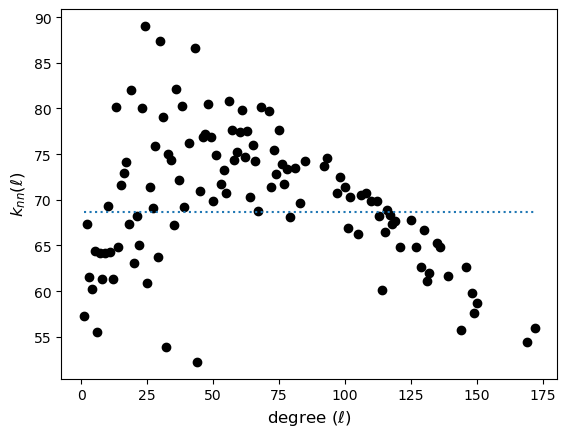

In [8]:
knn = deg_corr_directed(g,'out','in')
x = list(knn.keys())
y = list(knn.values())
r = deg_corr_neutral(g,'in')
plt.scatter(x,y,c='black')
plt.hlines(y=r,xmin=min(x),xmax=max(x),linestyles=':')
plt.xlabel(r'degree ($\ell$)',fontsize=12)
plt.ylabel(r'$k_{nn}(\ell)$',fontsize=12);
#plt.savefig('degree_corr_out_in.eps')


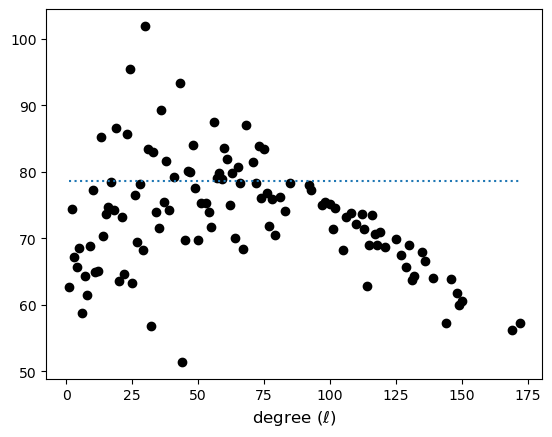

In [9]:
knn = deg_corr_directed(g,'out','out')
x = list(knn.keys())
y = list(knn.values())
r = deg_corr_neutral(g,'out')
plt.scatter(x,y,c='black')
plt.hlines(y=r,xmin=min(x),xmax=max(x),linestyles=':')
plt.xlabel(r'degree ($\ell$)',fontsize=12);
#plt.savefig('degree_corr_out_out.eps')


## Undirected airport graph

We now consider an undirected version of the airport graph. 
Degree correlation is quite similar to the previous plots, for the same reason the previous plots were similar. 

We plot both using linear and log scale.


In [10]:
## consider undirected graph
g = g.as_undirected()
g.es()['color'] = cls_edges


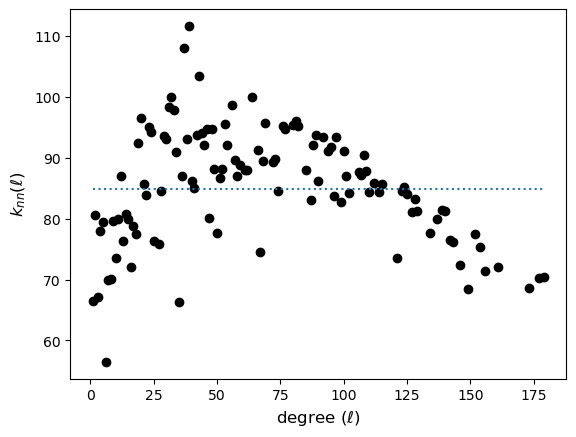

In [11]:
## linear scale plot
knn = deg_corr(g)
x = list(knn.keys())
y = list(knn.values())
r = deg_corr_neutral(g)
plt.scatter(x,y,c='black')
plt.hlines(y=r,xmin=min(x),xmax=max(x),linestyles=':')
plt.xlabel(r'degree ($\ell$)',fontsize=12)
plt.ylabel(r'$k_{nn}(\ell)$',fontsize=12);
#plt.savefig('degree_corr_linear.eps')


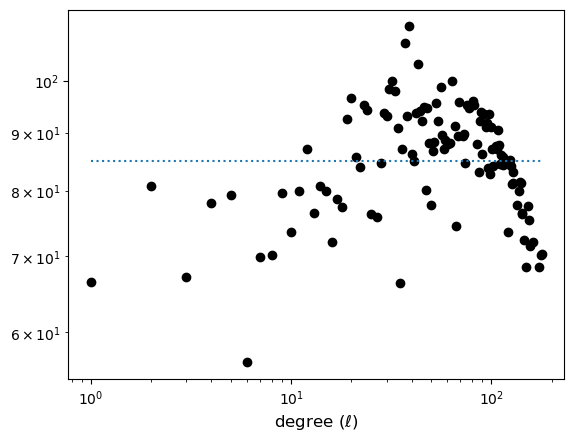

In [12]:
## log scale plot
plt.loglog(x,y,'o',c='black')
plt.hlines(y=r,xmin=min(x),xmax=max(x),linestyles=':')
plt.xlabel(r'degree ($\ell$)',fontsize=12);
#plt.savefig('degree_corr_log.eps');

# State by state assortativity and correlation exponent

We consider each state in the airport graph with more than 5 vertices having in-state edges.
We compute the following quantities defined in section 4.3:

* the degree correlation coefficient, or assortativity ($r$)
* the correlation exponent ($\mu$) estimated via regression


In [13]:
## compute r and mu for each state, store in data frame and sort w.r.t. r (assortativity)
L = []
for s in set(list(A['state'])):
    ## Build state subgraph
    hva = [v for v in g.vs() if v['state'] == s]
    G = g.subgraph(hva)
    ## drop isolated vertices (i.e. without in-state connections)
    G = G.subgraph([v for v in G.vs() if v.degree()>0])
    ## remove loops
    G = G.simplify(multiple=False)
    ## only consider graphs with > 5 vertices
    if G.vcount() >= 6:
        mu = corr_exp(G)        
        L.append([s,G.vcount(),G.ecount(),G.assortativity_degree(),mu])
P = pd.DataFrame(L,columns=['state','nodes','edges','assortativity','mu'])
P = P.sort_values(by='assortativity')

In [14]:
## show top states w.r.t. 'r' (lowest assortativity; min possible value is -1)
df = P.head(5)
df

,state,nodes,edges,assortativity,mu
9,NE,6,4,-1.000000,-1.000000
22,MN,6,6,-0.833333,-0.801870
20,UT,6,6,-0.833333,-0.801870
13,AZ,7,9,-0.601423,-0.612467
10,MO,11,18,-0.546798,-0.344853


In [15]:
## show bottom states w.r.t. 'r' (high, positive assortativity)
df = P.tail(3)
df

,state,nodes,edges,assortativity,mu
1,SD,6,7,0.263158,0.268328
18,ND,6,6,0.400000,0.858867
16,AR,7,9,1.000000,1.000000


### Correlation between $r$ and $\mu$

Some states are quite small (very few nodes and edges), but we still see good correlation between those quantities.

Person correlation: 0.9649505377639607


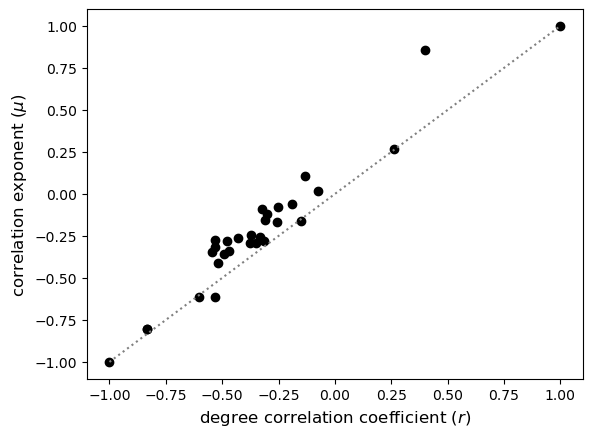

In [16]:
## correlation between r and mu
plt.plot(P['assortativity'],P['mu'],'o',color='black')
plt.xlabel('degree correlation coefficient ($r$)',fontsize=12)
plt.ylabel(r'correlation exponent ($\mu$)',fontsize=12)
print('Person correlation:',np.corrcoef(P['assortativity'],P['mu'])[1,0])
ident = [-1.0, 1.0]
plt.plot(ident,ident,':',c='gray');
#plt.savefig('mu.eps')

# Looking at a few states with high/low assortativity

## Positive assortativity: ND+SD

We merge the graphs from North and South Dakota; the resulting graph has positive assortativity value $r$ = 0.243. 
We notice the presence of a dense region (interconnected high degree nodes) and some tendrils with low degree nodes. 


r = 0.24324324324324392


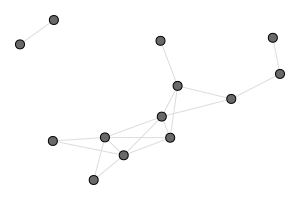

In [17]:
## positive assortativity: the Dakotas (ND+SD)
hva = [v for v in g.vs() if v['state'] == 'SD' or v['state'] == 'ND']
G_D = g.subgraph(hva)
G_D = G_D.subgraph([v for v in G_D.vs() if v.degree()>0])
G_D = G_D.simplify(multiple=False)
print('r =',G_D.assortativity_degree())
#ig.plot(G_D, "ND_SD.eps", bbox=(0,0,300,200))
ig.plot(G_D, bbox=(0,0,300,200))

Below we compare $r$ and $\mu$ vs random models for the Dakotas graph G_D.
We use the configuration model from Viger and Latapy; we also report the proportion of nodes above the structural cutoff given the degree distribution.

The resulting values are quite different from the real graph.

r = 0.24324324324324392 mu = 0.3825272963623285 
P(edges above structural cutoff) = 0.0


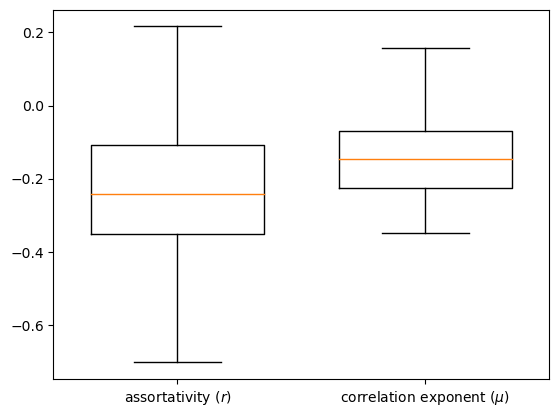

In [18]:
## r and mu for 1000 random graphs via Viger-Latapy model
r = []
mu = []
for i in range(1000):    
    cm = ig.Graph.Degree_Sequence(G_D.degree(),method="vl")
    r.append(cm.assortativity_degree())
    mu.append(corr_exp(cm))
## structural cutoff
sc = np.sqrt(2*G_D.ecount())
p = len([x for x in G_D.degree() if x > sc])/G_D.vcount()
print('r =',G_D.assortativity_degree(),'mu =',corr_exp(G_D),'\nP(edges above structural cutoff) =', p)
plt.boxplot([r,mu],labels=[r'assortativity ($r$)',r'correlation exponent ($\mu$)'],widths=.7,sym='');
#plt.savefig('config_D.eps');

Another way to see this is to plot the degree correlation functions for the real graphs and for one of the generated configuration model graphs, which we show below.

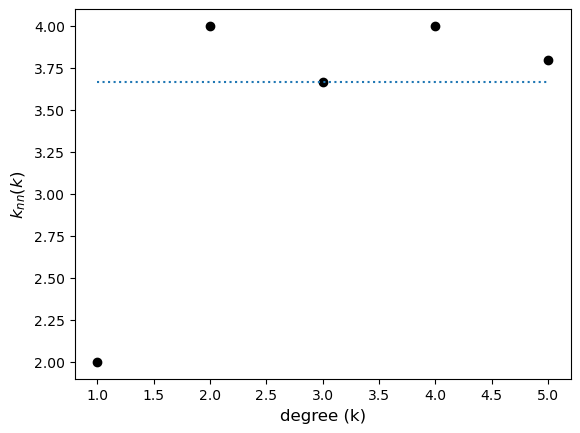

In [19]:
## degree correlation function for the Dakotas graph
## dotted line: neutral graph value
knn = deg_corr(G_D)
x = list(knn.keys())
y = list(knn.values())
r = deg_corr_neutral(G_D)
plt.scatter(x,y,c='black')
plt.hlines(y=r,xmin=min(x),xmax=max(x),linestyles=':')
plt.xlabel('degree (k)',fontsize=12)
plt.ylabel(r'$k_{nn}(k)$',fontsize=12);
#plt.savefig('degree_corr_D.eps')

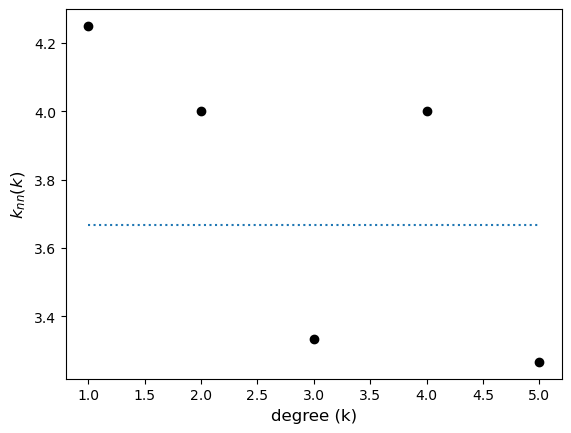

In [20]:
## degree correlation function for a configuration model random graph
## quite different!
knn = deg_corr(cm)
x = list(knn.keys())
y = list(knn.values())
r = deg_corr_neutral(cm)
plt.scatter(x,y,c='black')
plt.hlines(y=r,xmin=min(x),xmax=max(x),linestyles=':')
plt.xlabel('degree (k)',fontsize=12)
plt.ylabel(r'$k_{nn}(k)$',fontsize=12);
#plt.savefig('degree_corr_MO_cm.eps')

## Negative assortativity: MO

We plot the graph for MO (Missouri) which has negative assortativity value r = -0.547. We see that in this graph the low degree nodes mostly connect to the large degree hub nodes.


r = -0.546798029556649


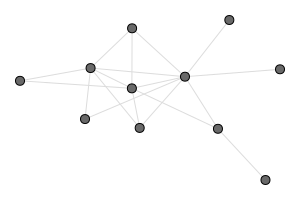

In [21]:
## negative case: the MO graph (Missouri) 
hva = [v for v in g.vs() if v['state'] == 'MO' ]
G_MO = g.subgraph(hva)
G_MO = G_MO.subgraph([v for v in G_MO.vs() if v.degree()>0])
G_MO = G_MO.simplify(multiple=False)
print('r =',G_MO.assortativity_degree())
#ig.plot(G_MO, "MO.eps", bbox=(0,0,300,200))
ig.plot(G_MO, bbox=(0,0,300,200))

Below we compare $r$ and $\mu$ vs random models for the MO graph G_MO.
We use the configuration model from Viger and Latapy; we also report the proportion of nodes above the structural cutoff given the degree distribution.

The values are similar to the ones for the real graph. Therefore, in that case, the resulting values for $r$ and $\mu$ can mostly be explained by the degree distribution: hubs are forced to be adjacent to small degree nodes. 


r = -0.546798029556649 mu = -0.34485253746081135 P(edges above structural cutoff) = 0.09090909090909091


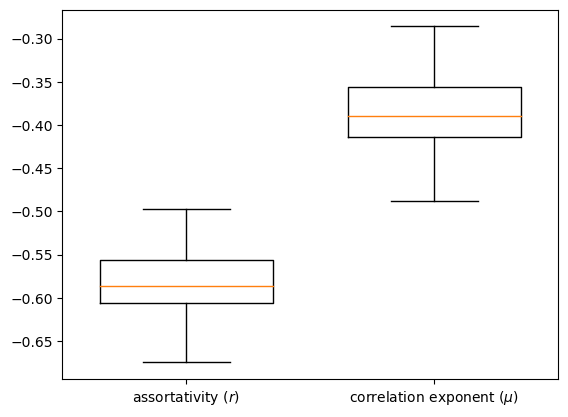

In [22]:
## r and mu vs random configuration model for MO graph
r = []
mu = []
for i in range(1000):    
    cm = ig.Graph.Degree_Sequence(G_MO.degree(),method="vl")
    r.append(cm.assortativity_degree())
    mu.append(corr_exp(cm))
## structural cutoff
sc = np.sqrt(2*G_MO.ecount())
p = len([x for x in G_MO.degree() if x > sc])/G_MO.vcount()
print('r =',G_MO.assortativity_degree(),'mu =',corr_exp(G_MO),'P(edges above structural cutoff) =', p)
plt.boxplot([r,mu],labels=[r'assortativity ($r$)',r'correlation exponent ($\mu$)'],widths=.7,sym='');
#plt.savefig('config_MO.eps');

Results are very similar if we use simple "rejection sampling" for the configuration model.
This is however much slower. Un-comment the cell below to run.

Another way to see this is to plot the degree correlation functions for the real graphs and for one of the generated configuration model graphs, which we show below.

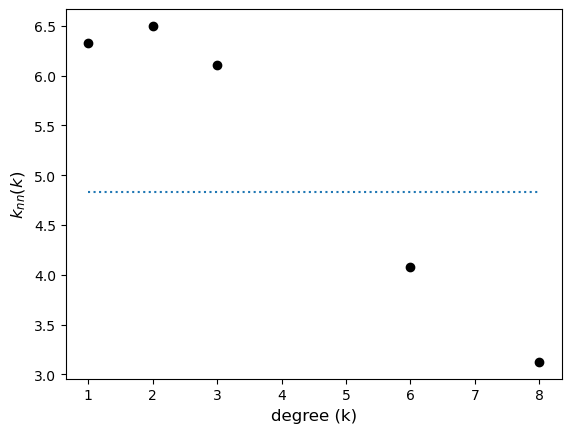

In [23]:
## degree correlation function for MO graph
knn = deg_corr(G_MO)
x = list(knn.keys())
y = list(knn.values())
r = deg_corr_neutral(G_MO)
plt.scatter(x,y,c='black')
plt.hlines(y=r,xmin=min(x),xmax=max(x),linestyles=':')
plt.xlabel('degree (k)',fontsize=12)
plt.ylabel(r'$k_{nn}(k)$',fontsize=12);
#plt.savefig('degree_corr_MO.eps')

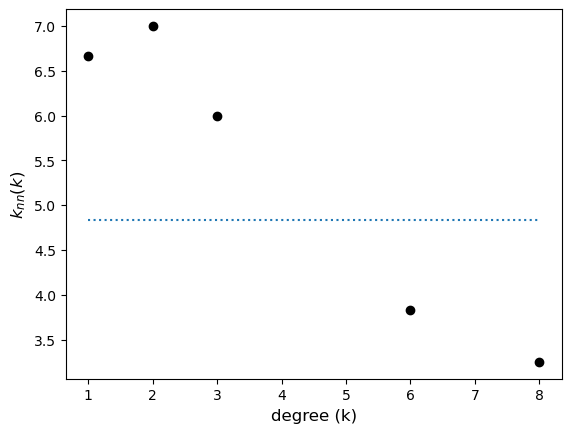

In [24]:
## degree correlation function for a configuration random graph
## quite similar!
knn = deg_corr(cm)
x = list(knn.keys())
y = list(knn.values())
r = deg_corr_neutral(cm)
plt.scatter(x,y,c='black')
plt.hlines(y=r,xmin=min(x),xmax=max(x),linestyles=':')
plt.xlabel('degree (k)',fontsize=12)
plt.ylabel(r'$k_{nn}(k)$',fontsize=12);
#plt.savefig('degree_corr_MO_cm.eps')

## Assortativity: two extreme cases

Below we show two small state subgraphs with $r=-1$ (NE) and $r=1$ (AR).
The AR graph consists of two cliques, so each node has the same degree as its neighbour. On the other hand, in the NE graph every node of degree 1 has a neighbour of degree 2, and nodes of degree 2 have 2 neighbours of degree 1. 


r = -1.0


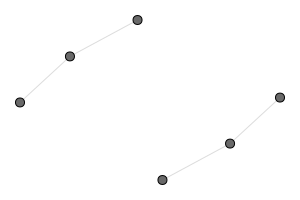

In [25]:
## state with r = -1 (NE)
hva = [v for v in g.vs() if v['state'] == 'NE' ]
G = g.subgraph(hva)
G = G.subgraph([v for v in G.vs() if v.degree()>0])
G = G.simplify(multiple=False)
print('r =',G.assortativity_degree())
#ig.plot(G, "NE.eps", bbox=(0,0,300,200))
ig.plot(G,bbox=(0,0,300,200))

r = 1.0


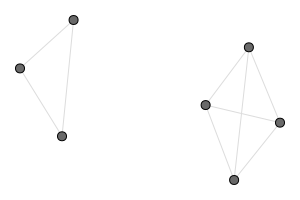

In [26]:
## state with r = +1 (AR) 
hva = [v for v in g.vs() if v['state'] == 'AR' ]
G = g.subgraph(hva)
G = G.subgraph([v for v in G.vs() if v.degree()>0])
G = G.simplify(multiple=False)
print('r =',G.assortativity_degree())
#ig.plot(G, "AR.eps", bbox=(0,0,300,200))
ig.plot(G, bbox=(0,0,300,200))

## Back to Overall US Airport graph 

We go back to the full (undirected) US airport graph in order to illustrate two concepts:

* the friendship "paradox" 
* the rich club phenomenon, if any

For each node, we compare its degree with the average degree of its neighbours. We draw a line with unit slope to highlight the fact that the region above that line is much denser. This is due to the fact that there are many low degree nodes (smaller airports) which mostly tend to connect to hub airports, which explains the presence of this “paradox.”

Next we compute the rich-club ratio $\rho(l)$ for all values of $l$. We see that the curve starts at 1, increases slightly before decreasing gradually. We conclude that there is no indication of a rich-club phenomenon here.


r = -0.055426395333393004


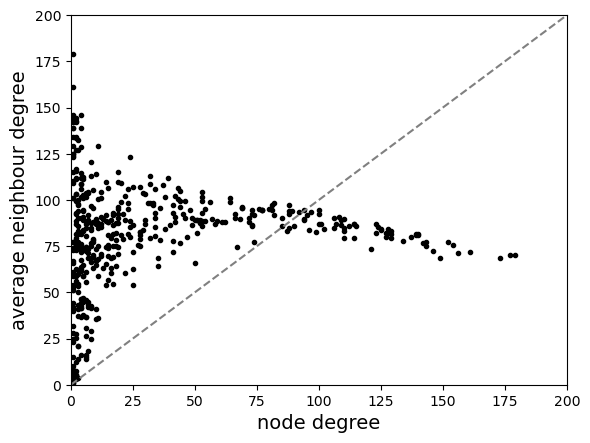

In [27]:
## plot degree vs avg neighbour degree
## friendship 'paradox' US Airport graph (overall)
deg = [v.degree() for v in g.vs()]
nad = []
for v in g.vs():
    nv = g.neighbors(v)
    nad.append(np.mean([deg[i] for i in nv]))

plt.scatter(deg,nad,c='black',marker='.')
plt.xlim((0,200))
plt.ylim((0,200))
plt.xlabel('node degree', fontsize=14)
plt.ylabel('average neighbour degree', fontsize=14);
plt.plot([0,200],[0,200],'--', c='gray')
print('r =',g.assortativity_degree());
#plt.savefig('friendship.eps')

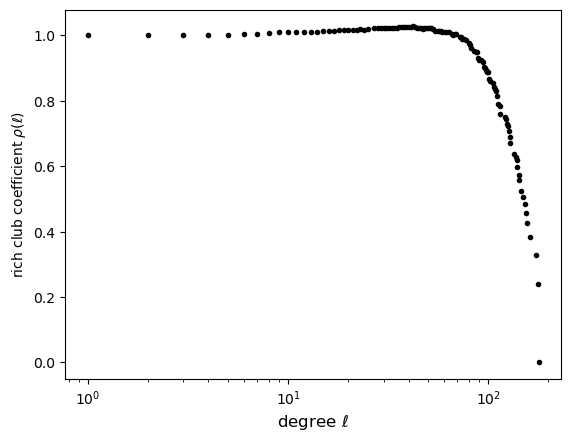

In [28]:
## looking for rich club -- not here!
d = list(set(g.degree()))
rc = []
for i in d:
    rc.append(rich_club(g, l=i))
plt.semilogx(d,rc,'.',c='black')
plt.xlabel(r'degree $\ell$',fontsize=12)
plt.ylabel(r'rich club coefficient $\rho(\ell)$');
#plt.savefig('rich_club.eps');

## Quick look: Europe Electric Grid Network

This is a graph we saw before. 
Recall that the degree distribution is quite uniform (no high degree node, for example).

We notice a small, but positive assortativity $r$, which we also see on the degree correlation function plot.
From the average neighbour degree plot, the friendship paradox is not obvious here, mainly due to the absence of high degree "hub" nodes.


In [29]:
## Europe Electric Grid
grid = ig.Graph.Read_Ncol(datadir+'GridEurope/gridkit_europe-highvoltage.edges', directed=False)
grid = grid.simplify()

r = 0.01444296570358029


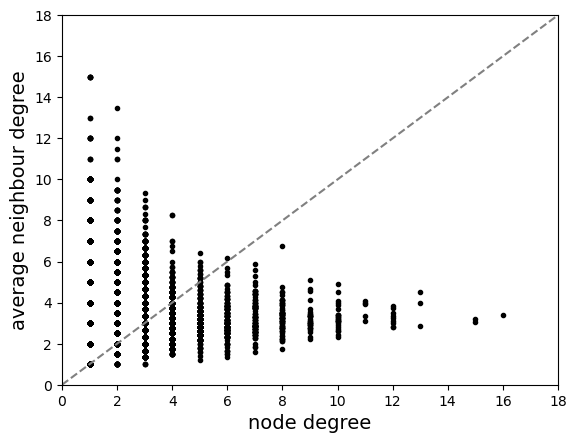

In [30]:
## plot degree vs avg neighbour degree
deg = [v.degree() for v in grid.vs()]
nad = []
for v in grid.vs():
    nv = grid.neighbors(v)
    nad.append(np.mean([deg[i] for i in nv]))

plt.scatter(deg,nad,c='black',marker='.')
plt.xlim((0,18))
plt.ylim((0,18))
plt.xlabel('node degree', fontsize=14)
plt.ylabel('average neighbour degree', fontsize=14);
plt.plot([0,18],[0,18],'--', c='gray')
print('r =',grid.assortativity_degree());
#plt.savefig('friendship_grid.eps')

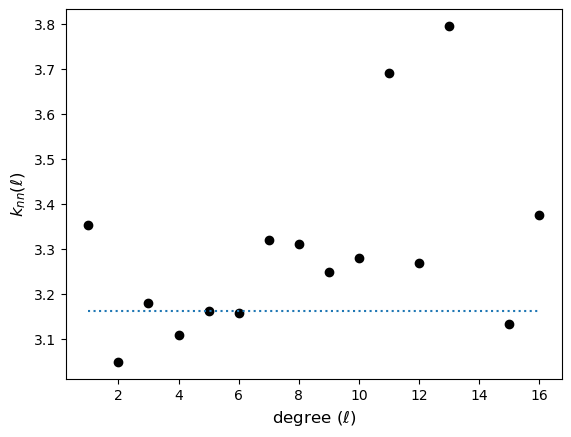

In [31]:
## Degree correlation function
knn = deg_corr(grid)
x = list(knn.keys())
y = list(knn.values())
r = deg_corr_neutral(grid)
plt.scatter(x,y,c='black')
plt.hlines(y=r,xmin=min(x),xmax=max(x),linestyles=':')
plt.xlabel(r'degree ($\ell$)',fontsize=12)
plt.ylabel(r'$k_{nn}(\ell)$',fontsize=12);
#plt.savefig('degree_corr_grid.eps')

## Quick look: GitHub Developers Graph

This is a graph we saw before. 

Here, we observe negative assortativity, which is common for social networks, and we also strongly observe the friendship paradox phenomenon.

Despite the presence of high degree nodes, there is no evidence of the rich club phenomenon in this graph.

In [32]:
## GitHub Developers (undirected)
D = pd.read_csv(datadir+'GitHubDevelopers/musae_git_edges.csv')
tuples = [tuple(x) for x in D.values]
git = ig.Graph.TupleList(tuples, directed = False)

r = -0.07521713413904484


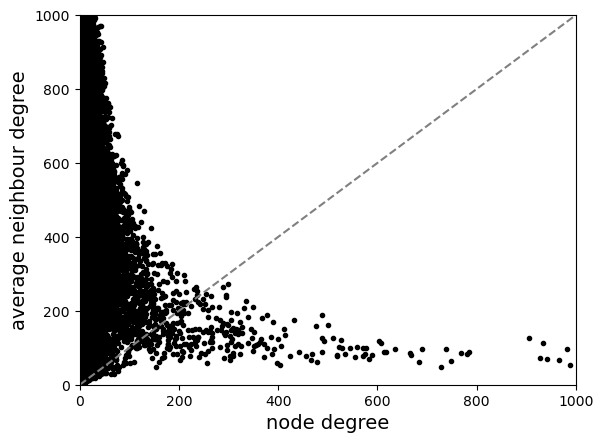

In [33]:
## plot degree vs avg neighbour degree
## zoom in on nodes with degree < LIM
LIM = 1000
deg = [v.degree() for v in git.vs()]
nad = []
for v in git.vs():
    nv = git.neighbors(v)
    nad.append(np.mean([deg[i] for i in nv]))

plt.scatter(deg,nad,c='black',marker='.')
plt.xlim((0,LIM))
plt.ylim((0,LIM))
plt.xlabel('node degree', fontsize=14)
plt.ylabel('average neighbour degree', fontsize=14);
plt.plot([0,LIM],[0,LIM],'--', c='gray')
print('r =',git.assortativity_degree());
#plt.savefig('friendship_github.eps')

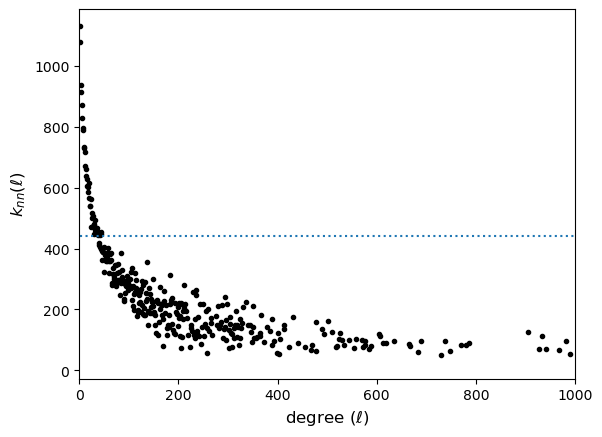

In [34]:
## degree correlation function
knn = deg_corr(git)
x = list(knn.keys())
y = list(knn.values())
idx = np.random.choice(len(x),100,replace=False)
r = deg_corr_neutral(git)
plt.xlim((0,LIM))
plt.scatter(x,y,marker='.',c='black')
plt.hlines(y=r,xmin=min(x),xmax=max(x),linestyles=':')
plt.xlabel(r'degree ($\ell$)',fontsize=12)
plt.ylabel(r'$k_{nn}(\ell)$',fontsize=12);
#plt.savefig('degree_corr_github.eps')

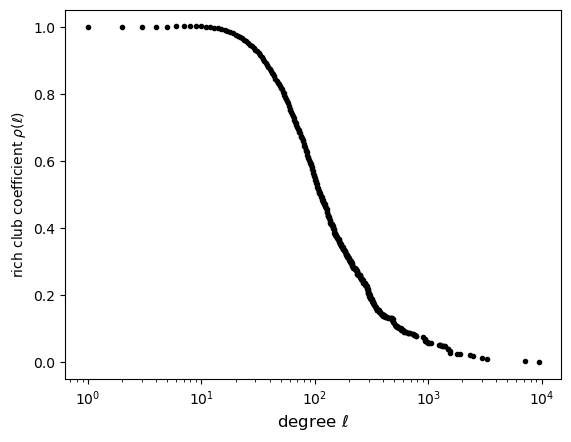

In [35]:
## still no rich club group here
d = list(set(git.degree()))
rc = []
for i in d:
    rc.append(rich_club(git, l=i))
plt.semilogx(d,rc,'.',c='black')
plt.xlabel(r'degree $\ell$',fontsize=12)
plt.ylabel(r'rich club coefficient $\rho(\ell)$');
#plt.savefig('rich_club_github.eps');

## Showing a Rich Club phenomenon: the Actors graph

This data set is part of the accompanying material of the book "Complex Networks: Principles, Methods and Applications", V. Latora, V. Nicosia, G. Russo, Cambridge University Press (2017).

It has 248,243 nodes (actors) and 8,302,734 edges (actors co-appearing in at least 1 movie).

We use this data to illustrate the presence of a "rich club", which may be explained by the fact that famous actors tend to play in many movies (high degree) and with other famous actors (rich-club phenomenon).

To speed up the computation, we sample 200 distinct node degrees appearing in the graph for which we compute and plot the rich club coefficient. This can still take a few minutes to complete.


In [36]:
## Actors graph
D = pd.read_csv(datadir+'Actors/movie_actors.net', sep=' ', header=None)
tuples = [tuple(x) for x in D.values]
g = ig.Graph.TupleList(tuples, directed = False)

## This can be slow -- you may want to take a sample first
d = np.random.choice(list(set(g.degree())),size=200,replace=False) ## sample
#d = list(set(g.degree())) ## full; plot in book obtained with full set of values

rc = []
for i in d:
    rc.append(rich_club(g, l=i))

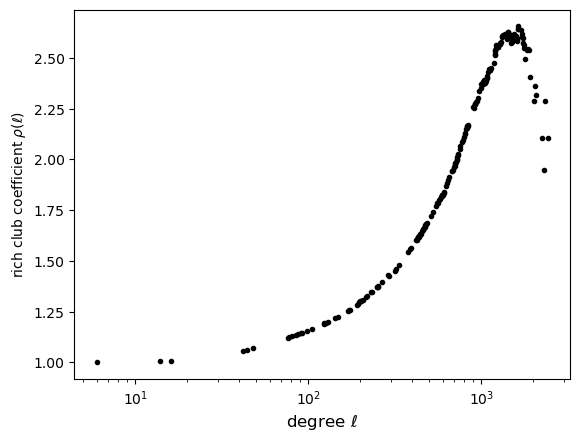

In [37]:
## rich club coefficients
plt.semilogx(d,rc,'.',c='black')
plt.xlabel(r'degree $\ell$',fontsize=12)
plt.ylabel(r'rich club coefficient $\rho(\ell)$');
#plt.savefig('rich_club_actors.eps')

## Figures 4.1 and 4.2: Xulvi-Brunet and Sokolov (XBS) algorithm

The figures in the book were obtained with the faster Julia code. 
We show a smaller scale example here. (smaller value for $N$ and less repeats).

* Fig. 4.1: degree correlation function for various assortativity values, using XBS algorithm
* Fig. 4.2: order of the giant component vs expected average degree


In [38]:
## Naive Xulvi-Brunet and Sokolov algorithm
def XBS(n, d, q, assortative):
    p = d/n
    g = ig.Graph.Erdos_Renyi(n,p)
    g.es['touched'] = False
    ec = g.ecount()
    while True:
        re = np.random.choice(ec, 2, replace=False)
        nodes = list(g.es[re[0]].tuple+g.es[re[1]].tuple)
        if len(set(nodes))==4:
            ## with proba q, wire w.r.t. assortativity, else randomly
            if np.random.random()<q:
                idx = np.argsort(g.degree(nodes))
                if assortative:
                    e1 = (nodes[idx[0]],nodes[idx[1]])
                    e2 = (nodes[idx[2]],nodes[idx[3]])
                else:
                    e1 = (nodes[idx[0]],nodes[idx[3]])
                    e2 = (nodes[idx[1]],nodes[idx[2]])
            else:
                np.random.shuffle(nodes)
                e1 = (nodes[0],nodes[1])
                e2 = (nodes[2],nodes[3])
            if g.get_eid(e1[0], e1[1], directed=False, error=False)+\
               g.get_eid(e2[0], e2[1], directed=False, error=False) == -2:
                    g.delete_edges(re)
                    g.add_edge(e1[0],e1[1],touched=True)
                    g.add_edge(e2[0],e2[1],touched=True)
            else:
                g.es[re[0]]['touched']=True
                g.es[re[1]]['touched']=True
        if sum(g.es['touched']) == g.ecount():
            break
    return g

/Users/hoangnguyen/miniconda3/envs/graphmining/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  


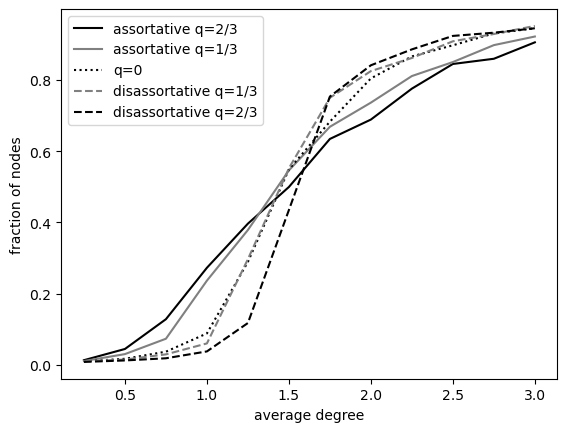

In [39]:
## Generating Figure 4.2 with N nodes and averaging over Rep results
N = 2**9 ## we use 2**16 and Rep=64 in the book using Julia 
Rep = 8

Q = [2/3,1/3,0,1/3,2/3]
A = [True,True,True,False,False]
x = np.arange(0.25,3.01,.25)
Y = []

for i in range(len(Q)):
    y = []
    for d in x:
        sz = 0
        for rep in range(Rep):
            g = XBS(n = N, d = d, q = Q[i] , assortative = A[i])
            sz += g.clusters().giant().vcount()/g.vcount()
        y.append(sz / Rep)
    Y.append(y)
    
clr = ['black','gray','black','gray','black']
typ = ['-','-',':','--','--']
lbl = ['assortative q=2/3','assortative q=1/3','q=0','disassortative q=1/3','disassortative q=2/3']
for i in range(len(Y)):
    plt.plot(x,Y[i],color=clr[i],linestyle=typ[i],label=lbl[i])
plt.xlabel('average degree')
plt.ylabel('fraction of nodes')
plt.legend();


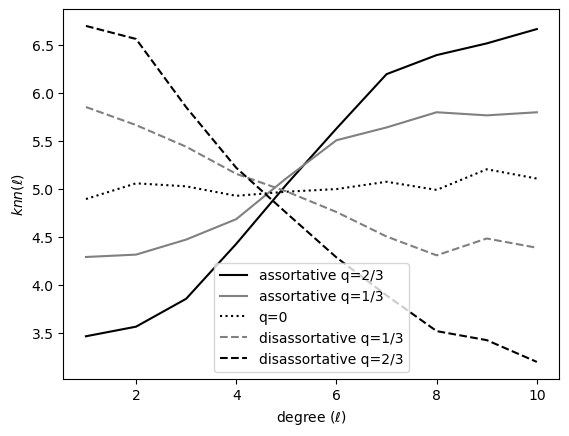

In [40]:
## Generating Figure 4.1 with N nodes and averaging over Rep results
Y = []
for i in range(len(Q)):
    D = pd.DataFrame()
    for rep in range(Rep):
        g = XBS(n = N, d = 4, q = Q[i] , assortative = A[i])
        deg = g.degree()
        g.delete_vertices([i for i in range(len(deg)) if deg[i]==0])
        knn = deg_corr(g)
        D = pd.concat([D,pd.DataFrame(np.transpose(np.array([list(knn.keys()),list(knn.values())])))])
    X = D.groupby(by=0).mean()
    plt.plot(list(X.index)[:10],list(X[1])[:10],color=clr[i],linestyle=typ[i],label=lbl[i])
plt.xlabel(r'degree ($\ell$)')
plt.ylabel(r'$knn(\ell)$')
plt.legend();